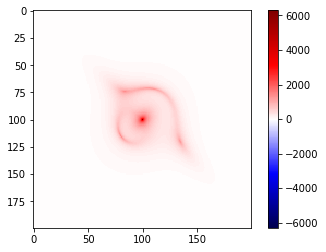

In [4]:
from helpers import CustomImage, autoshow

blankimg = CustomImage([],[],[], zl=0.5, pixnum=200, pixsize=.008*40)

autoshow(blankimg.image)

In [1]:
from helpers import CustomImage, autoshow

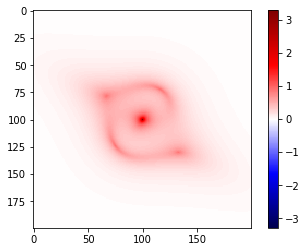

In [2]:
blankimg = CustomImage([],[],[], zl=0.5, pixnum=200, pixsize=.008)

autoshow(blankimg.image)

In [1]:
mylist = [1,3,3,7]
{z:0 for z in mylist}

{1: 0, 3: 0, 7: 0}

In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.316)
cosmo.comoving_distance(0.5)

<Quantity 1878.26610075 Mpc>

In [5]:
cosmo.angular_diameter_distance_z1z2(0.1, 0.5)

<Quantity 973.54021907 Mpc>

# Test PSO

18 November 2019

In [12]:
# Import modules
import numpy as np

# Import PySwarms (pip install pyswarms pyyaml)
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


In [14]:

%%time
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options)

# Perform optimization
cost, pos = optimizer.optimize(fx.sphere, iters=1000)



2019-11-18 21:57:03,565 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'w': 0.9, 'c2': 0.3}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=3.76e-44
2019-11-18 21:57:04,672 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.763289322434694e-44, best pos: [-1.29161489e-22 -1.44741850e-22]


CPU times: user 1.17 s, sys: 136 ms, total: 1.3 s
Wall time: 1.11 s


In [15]:
cost

3.763289322434694e-44

In [16]:
pos

array([-1.29161489e-22, -1.44741850e-22])

In [17]:
# create a parameterized version of the classic Rosenbrock unconstrained optimzation function
def rosenbrock_with_args(x, a, b, c=0):
    f = (a - x[:, 0]) ** 2 + b * (x[:, 1] - x[:, 0] ** 2) ** 2 + c
    return f

In [18]:
cost, pos = optimizer.optimize(rosenbrock_with_args, 1000, a=1, b=100, c=0)

2019-11-18 21:59:05,354 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'w': 0.9, 'c2': 0.3}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=3.76e-44
2019-11-18 21:59:06,469 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.763289322434694e-44, best pos: [4.21758234e-15 7.38154598e-23]


In [19]:
cost, pos

(3.763289322434694e-44, array([4.21758234e-15, 7.38154598e-23]))

# Dynesty test

18 November 2019

From the crash course at [this site](https://dynesty.readthedocs.io/en/latest/crashcourse.html#crash-course).

In [ ]:
import numpy as np

# Define the dimensionality of our problem.
ndim = 3

# Define our 3-D correlated multivariate normal likelihood.
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms
Cinv = np.linalg.inv(C)  # define the inverse (i.e. the precision matrix)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim +
                np.log(np.linalg.det(C)))  # ln(normalization)

# Is the lnorm important? I hope not...

def loglike(x):
    """The log-likelihood function."""

    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    return 10. * (2. * u - 1.)

Estimate evidence and posterior:

In [ ]:
import dynesty

# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

# "Dynamic" nested sampling.
dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim)
dsampler.run_nested()
dresults = dsampler.results

Combine static and dynamic results:

In [ ]:
from dynesty import utils as dyfunc

# Combine results from "Static" and "Dynamic" runs.
results = dyfunc.merge_runs([sresults, dresults])

Plotting:

In [ ]:
%matplotlib inline

In [ ]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results)

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results)

Post-processing:

In [ ]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = results.samples  # samples
weights = np.exp(results.logwt - results.logz[-1])  # normalized weights

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(results)

# Test emcee parallelization

17 November 2019

In [ ]:
import time
import numpy as np


def log_prob(theta):
    t = time.time() + np.random.uniform(0.005, 0.008)
    while True:
        if time.time() >= t:
            break
    return -0.5 * np.sum(theta ** 2)

In [ ]:
import emcee

np.random.seed(42)
initial = np.random.randn(32, 5)
nwalkers, ndim = initial.shape
nsteps = 100

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)

In [ ]:
%%time
sampler.run_mcmc(initial, nsteps);

In [ ]:
from multiprocessing import Pool

In [ ]:
%%time
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)

    state = sampler.run_mcmc(initial, nsteps)

Wow! I should have done this so much sooner!

In [ ]:
%%time
with Pool() as pool:
    new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    
    new_sampler.run_mcmc(state, nsteps)